In [4]:
#Imports
import pandas as pd
import os
import tensorflow as tf
from tslearn.clustering import TimeSeriesKMeans
from keras import backend as K
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw

In [6]:
#Get data 

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd())))
df = pd.read_csv(cwd+'/data/Final_Energy_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter for the first 30 'load' and 'pv' columns using list comprehension
columns_to_keep = [
    col for col in df.columns 
    if (col.startswith('load_') or col.startswith('pv_')) and int(col.split('_')[1]) <= 30
]
filtered_df = df[columns_to_keep]

# Calculate prosumption for each user
prosumption_df = pd.DataFrame(index=df.index)
for i in range(1, 31):  # Assuming 30 users
    load_col = f'load_{i}'
    pv_col = f'pv_{i}'
    if load_col in filtered_df.columns and pv_col in filtered_df.columns:
        prosumption_df[f'prosumption_{i}'] = filtered_df[pv_col] - filtered_df[load_col]

#Only keep month 3,7,11 of the data to limit computational time
prosumption_df = prosumption_df[prosumption_df.index.month.isin([3, 7, 11])]
prosumption_df = prosumption_df[prosumption_df.index.day.isin([1,2,3,4,5,6,7,8,9,10])]

prosumption_df.head(1)

,prosumption_1,prosumption_2,prosumption_3,prosumption_4,prosumption_5,prosumption_6,prosumption_7,prosumption_8,prosumption_9,prosumption_10,...,prosumption_21,prosumption_22,prosumption_23,prosumption_24,prosumption_25,prosumption_26,prosumption_27,prosumption_28,prosumption_29,prosumption_30
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-01 00:30:00,-1.553,-0.085,-2.698,-0.075,-1.917,-0.044,-1.831,-0.124,-0.033,-0.031,...,-0.896,-0.072,-0.111,-0.146,-0.1,-0.375,-0.265,-0.1,-0.103,-2.461


In [7]:
#Prepare data

time_series = prosumption_df.T.values
# Scaling the data: Mean normalization to improve clustering
scaler = TimeSeriesScalerMeanVariance()
time_series_scaled = scaler.fit_transform(time_series)

In [8]:
# Function to compute DTW Within-Cluster Variance
def compute_dtw_within_cluster_variance(data, labels, centroids):
    clusters_dtw_variance = []
    for cluster_id in set(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_data = data[cluster_indices]
        centroid = centroids[cluster_id]
        dtw_distances = [dtw(cluster_data[i], centroid) for i in range(len(cluster_data))]
        clusters_dtw_variance.append(np.mean(dtw_distances))
    return np.mean(clusters_dtw_variance)

In [10]:
# Define the range of cluster counts to evaluate
max_clusters = 20
cluster_counts = range(2, max_clusters + 1)
db_scores = []
silhouette_scores = []
dtw_variances = []
cluster_labels = {}
density_scores = []
inter_cluster_distances = []

# Iterate over possible cluster counts
for cluster_count in cluster_counts:
    kmeans = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", max_iter=100, tol=1e-6, random_state=42)
    labels = kmeans.fit_predict(time_series_scaled)
    cluster_labels[cluster_count] = labels
    
    # Compute Distance Scores
    dtw_variance = compute_dtw_within_cluster_variance(time_series_scaled, labels, kmeans.cluster_centers_)
    dtw_variances.append(dtw_variance)

    db_score = davies_bouldin_score(time_series_scaled.reshape(time_series_scaled.shape[0], -1), labels)
    db_scores.append(db_score)

    sil_score = silhouette_score(time_series_scaled.reshape(time_series_scaled.shape[0], -1), labels, metric=lambda x, y: dtw(x.reshape(-1,1), y.reshape(-1,1)))*100
    silhouette_scores.append(sil_score)

    # Compute density and inter-cluster distance (defer normalization)
    density = np.mean([np.sum(labels == i) for i in range(cluster_count)]) / len(labels)
    density_scores.append(density)

    # Compute the average DTW distance between different cluster centers
    if cluster_count > 1:  # Calculate distances only if there is more than one cluster
        inter_distances = [dtw(kmeans.cluster_centers_[i], kmeans.cluster_centers_[j]) for i in range(cluster_count) for j in range(i+1, cluster_count)]
        inter_cluster_distances.append(np.mean(inter_distances))
    else:
        inter_cluster_distances.append(0) 
    #print(f"Cluster Count: {cluster_count}, max_iter: {kmeans.n_iter_}, Davies-Bouldin Score: {db_score}, Silhouette Score: {sil_score}, DTW Variance: {dtw_variance}")
    print(f"Cluster: {cluster_count}, max_iter: {kmeans.n_iter_}, DB Score: {db_score:.3f}, Sil Score: {sil_score:.3f}, DTW Var: {dtw_variance:.3f}, Density: {density:.3f}, InterClusterDist: {np.mean(inter_distances):.3f}")

# Normalize the density scores and inter-cluster distances
max_density = max(density_scores)
density_scores = [d / max_density for d in density_scores]
max_distance = max(inter_cluster_distances)
inter_cluster_distances = [d / max_distance for d in inter_cluster_distances]

# Determine the best cluster count (example: using a simple weighted formula)
# You might customize the criteria for choosing the best cluster count
weighted_scores = [silhouette_scores[i] - db_scores[i] + density_scores[i] + inter_cluster_distances[i] for i in range(len(cluster_counts))]
best_index = np.argmax(weighted_scores)
best_cluster_count = cluster_counts[best_index]
print(f"Best cluster count based on combined criteria: {best_cluster_count}")


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cluster_counts, db_scores, marker='o', color='b', label='Davies-Bouldin Score')
plt.plot(cluster_counts, silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.plot(cluster_counts, dtw_variances, marker='o', color='g', label='DTW Variance')
plt.plot(cluster_counts, density_scores, marker='o', color='purple', label='Normalized Density')
plt.plot(cluster_counts, inter_cluster_distances, marker='o', color='orange', label='Normalized Inter-Cluster Distance')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Values')
plt.legend()
plt.grid(True)
plt.show()

Cluster: 2, max_iter: 3, DB Score: 3.166, Sil Score: 12.399, DTW Var: 26.467, Density: 0.500, InterClusterDist: 33.211
Cluster: 3, max_iter: 3, DB Score: 4.001, Sil Score: 4.399, DTW Var: 26.675, Density: 0.333, InterClusterDist: 31.439


KeyboardInterrupt: 

In [ ]:
cluster_labels

C:\Users\rs1044\AppData\Local\Temp\ipykernel_7192\3663830711.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


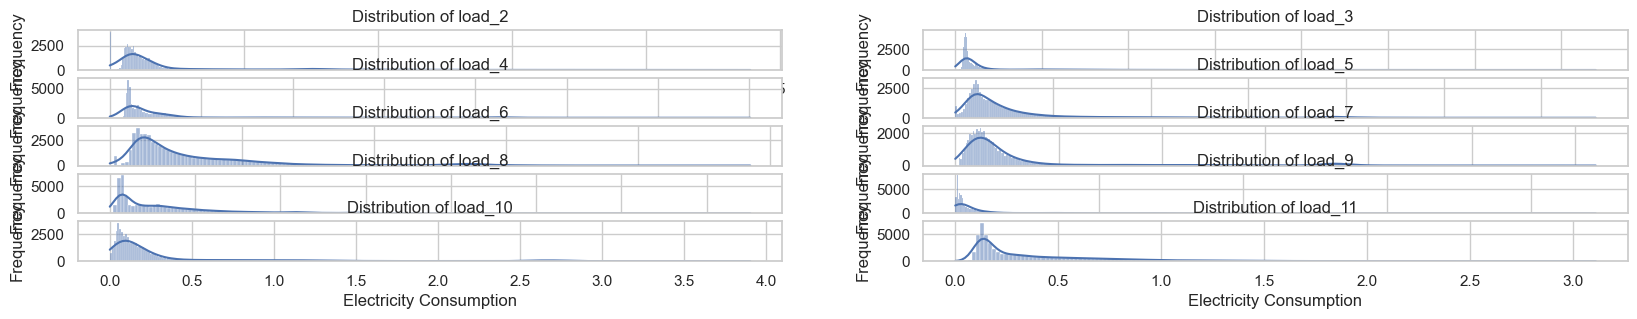

In [9]:
users_data = filtered_df.iloc[:, 1:11]

sns.set(style="whitegrid")
fig, axes = plt.subplots(5, 2, figsize=(20, 3))  # Adjust the size as needed
axes = axes.flatten()
for i, user in enumerate(users_data.columns):
    sns.histplot(users_data[user], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {user}')
    axes[i].set_xlabel('Electricity Consumption')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()